In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import tqdm

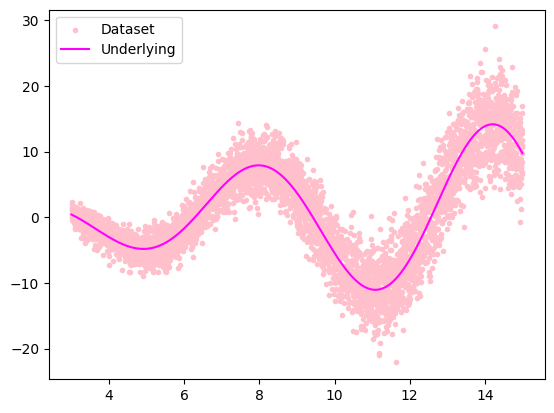

In [2]:
def f(x):
    return x * np.sin(x)

xMin = 3
xMax = 15
nSample = 5000

# input
x = np.linspace(xMin, xMax, nSample)
x_actual = np.linspace(xMin, xMax, nSample)
y_actual = f(x)

np.random.shuffle(x)

np.random.seed(17)
epsilon1 = np.random.normal(0.0, 0.3, nSample)
epsilon2 = np.random.normal(0.0, 0.3, nSample)

y = f(x) + epsilon1 + epsilon2 * x

plt.scatter(x, y, label = "Dataset", color = "pink", s = 9)
plt.plot(x_actual, y_actual, label = "Underlying", color = "magenta")
plt.legend()
plt.show()

X_train = x.reshape(-1, 1)
y_train = y.reshape(-1, 1)
X_test = np.arange(xMin, xMax+5, 0.01).reshape(-1, 1)

In [3]:
class GradientBoostedTreesEnsembleRegressor(tf.keras.Model):
    def __init__(self, n_trees=100, max_depth=3, n_estimators=100, sample_method='RANDOM'): 
        super(GradientBoostedTreesEnsembleRegressor, self).__init__()
        self.n_trees = n_trees
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.sample_method = sample_method
        self.estimators = []

    def build_estimator(self):
        model = tfdf.keras.GradientBoostedTreesModel(
            task=tfdf.keras.Task.REGRESSION,
            num_trees=self.n_trees,
            max_depth=np.random.randint(self.max_depth/2, self.max_depth+1),
            validation_ratio=0.1,
            sampling_method=self.sample_method,
            random_seed=self.seed # try to set this first. Maybe this is enough
        )
        return model
    
    # if not, the number of trees/depth different for each estimator

    def fit(self, X, y):
        num_data = X.shape[0]
        
        for seed in np.random.randint(0, 1000000, size=self.n_estimators):
            self.seed = int(seed) #passed to build_estimator
            
            # get the data index as a list
            indices = np.arange(num_data)
            indices = list(indices)
            
            # select a subset of indices for training
            train_estimator_size = int(len(indices)) 
            train_estimator_indices = np.random.choice(indices, size=train_estimator_size, replace=False)
            X_estimator_train = X[train_estimator_indices]
            y_estimator_train = y[train_estimator_indices]
            
            # building each estimator
            estimator = self.build_estimator()
            estimator.fit(X_estimator_train, y_estimator_train)
            
            self.estimators.append(estimator)

    def predict(self, X): # use all estimators
        predictions = []
        # sampled_estimators = np.random.choice(self.estimators, size=n_samples, replace=False)
        for estimator in self.estimators:
            estimator_predictions = []
            estimator_predictions.append(estimator.predict(X))
            estimator_predictions = tf.stack(estimator_predictions, axis=-1)
            predictions.append(tf.reduce_mean(estimator_predictions, axis=-1))
        predictions = tf.stack(predictions, axis=0)
        
        mean_prediction = tf.reduce_mean(predictions, axis=0)
        variance_prediction = tf.math.reduce_std(predictions, axis=0)
        return mean_prediction, variance_prediction



In [43]:
class Cali(tf.keras.Model):
    def __init__(self, n_trees=100, max_depth=3, n_estimators=100, subportion = 0.8, sample_method='RANDOM'): 
        super(Cali, self).__init__()
        self.n_trees = n_trees
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.subportion = subportion
        self.sample_method = sample_method
        self.estimators = []

    def build_estimator(self):
        model = tfdf.keras.GradientBoostedTreesModel(
            task=tfdf.keras.Task.REGRESSION,
            num_trees=np.random.randint(self.n_trees/5, self.n_trees+1), # self.n_trees, #
            max_depth=self.max_depth, #np.random.randint(self.max_depth/2, self.max_depth+1), # self.max_depth, # 
            validation_ratio=0.1,
            subsample=self.subportion,
            sampling_method=self.sample_method,
            random_seed=self.seed # try to set this first. Maybe this is enough
        )
        return model
    
    # if not, the number of trees/depth different for each estimator

    def fit(self, X, y):
        
        for seed in np.random.randint(0, 1000000, size=self.n_estimators):
            self.seed = int(seed)
            indices = np.arange(len(X))
            indices = list(indices)
            subset_size = int(self.subportion * len(X))
            
            # Create a subset of the dataset using sampled indices
            subset_indices = np.random.choice(indices, size=subset_size, replace=False)
            
            # X_train = X.loc[subset_indices].reset_index(drop=True)
            # y_train = y.loc[subset_indices].reset_index(drop=True)

            X_tensor = X[subset_indices]
            y_tensor = y[subset_indices]
            # X_tensor = tf.constant(X_train.values, dtype=tf.float32)
            # y_tensor = tf.constant(y_train.values, dtype=tf.float32)
        
            
            # subset_dataset = (X_tensor, y_tensor)
            
            # building each estimator
            estimator = self.build_estimator()
            estimator.fit(X_tensor,y_tensor)
            self.estimators.append(estimator)
    
    #something's not right here
    def predict(self, X): # use all estimators
        predictions = []
        # sampled_estimators = np.random.choice(self.estimators, size=n_samples, replace=False)
        for estimator in self.estimators:
            estimator_predictions = []
            estimator_predictions.append(estimator.predict(X))
            estimator_predictions = tf.stack(estimator_predictions, axis=-1)
            predictions.append(tf.reduce_mean(estimator_predictions, axis=-1))
        predictions = tf.stack(predictions, axis=0)
        
        mean_prediction = tf.reduce_mean(predictions, axis=0)
        variance_prediction = tf.math.reduce_std(predictions, axis=0)
        return mean_prediction, variance_prediction


In [44]:
gbt_model = GradientBoostedTreesEnsembleRegressor(
    n_trees=50, 
    max_depth=5, 
    n_estimators=80, 
    # subportion=0.3, 
    sample_method='RANDOM'
)

In [45]:
cali_model = Cali(
    n_trees=50, 
    max_depth=5, 
    n_estimators=80, 
    subportion=0.8, 
    sample_method='RANDOM'
)

In [46]:
cali_model.fit(X_train, y_train)

Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvxt1d9ay as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093514. Found 4000 examples.
Training model...
Model trained in 0:00:00.021562
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5bwnlvv6 as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:35.3817 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:35.3817 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:35.3817 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:35.4990 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvxt1d9ay/model/ with prefix b92ed7933f7a44a1
[INFO 24-05-08 18:01:35.4995 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-08 18:01:35.4995 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:35.5553 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:35.5553 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.083800. Found 4000 examples.
Training model...
Model trained in 0:00:00.049014
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuptg0y3t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084246. Found 4000 examples.
Training model...
Model trained in 0:00:00.045069
Compiling model...


[INFO 24-05-08 18:01:35.6889 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5bwnlvv6/model/ with prefix 422a145337e84ff4
[INFO 24-05-08 18:01:35.6901 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:35.7437 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:35.7437 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:35.7437 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:35.8755 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuptg0y3t/model/ with prefix 997e3a4fd6a04ec7
[INFO 24-05-08 18:01:35.8766 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy1hkyl8i as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.081586. Found 4000 examples.
Training model...
Model trained in 0:00:00.058709
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprz8d4qg4 as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:35.9328 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:35.9328 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:35.9328 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:36.0738 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy1hkyl8i/model/ with prefix 984f1535b67f43a8
[INFO 24-05-08 18:01:36.0753 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:36.1295 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:36.1295 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:36.1295 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.081098. Found 4000 examples.
Training model...
Model trained in 0:00:00.022643
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplj11cbfx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082574. Found 4000 examples.
Training model...
Model trained in 0:00:00.056174
Compiling model...


[INFO 24-05-08 18:01:36.2358 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprz8d4qg4/model/ with prefix f8c7c30cac2a4e3f
[INFO 24-05-08 18:01:36.2364 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:36.2945 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:36.2945 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:36.2946 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:36.4340 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplj11cbfx/model/ with prefix 3301e8717d0f4380
[INFO 24-05-08 18:01:36.4353 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbz6vt55n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084059. Found 4000 examples.
Training model...
Model trained in 0:00:00.043380
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjnrxwbqy as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:36.4989 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:36.4989 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:36.4989 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:36.6300 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbz6vt55n/model/ with prefix ed93dc4dc3ac4559
[INFO 24-05-08 18:01:36.6311 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:36.7006 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:36.7006 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:36.7006 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.092800. Found 4000 examples.
Training model...
Model trained in 0:00:00.038715
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpje7t2qba as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.081250. Found 4000 examples.
Training model...
Model trained in 0:00:00.058170
Compiling model...


[INFO 24-05-08 18:01:36.8367 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjnrxwbqy/model/ with prefix 4af86ab61a214709
[INFO 24-05-08 18:01:36.8377 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:36.8924 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:36.8924 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:36.8924 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:37.0339 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpje7t2qba/model/ with prefix 0603fc24f0df40f0
[INFO 24-05-08 18:01:37.0353 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph9fzk3cl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082222. Found 4000 examples.
Training model...
Model trained in 0:00:00.057797
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp15pt7_qj as temporary training directory


[WARNING 24-05-08 18:01:37.0918 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:37.0918 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:37.0918 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:37.2327 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph9fzk3cl/model/ with prefix 09a5ef247a714e7d
[INFO 24-05-08 18:01:37.2343 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:37.2891 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:37.2891 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:37.2891 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.083619. Found 4000 examples.
Training model...
Model trained in 0:00:00.041337
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc89mb8i4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083359. Found 4000 examples.
Training model...
Model trained in 0:00:00.018238
Compiling model...


[INFO 24-05-08 18:01:37.4172 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp15pt7_qj/model/ with prefix c3b42bfcd7f84087
[INFO 24-05-08 18:01:37.4183 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:37.4715 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:37.4715 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:37.4715 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:37.5750 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc89mb8i4/model/ with prefix e6b7d10ca563498d
[INFO 24-05-08 18:01:37.5755 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqs9ue9ik as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082837. Found 4000 examples.
Training model...
Model trained in 0:00:00.021558
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_1dyr7ho as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:37.6294 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:37.6294 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:37.6294 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:37.7369 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqs9ue9ik/model/ with prefix 07408e9364f045b4
[INFO 24-05-08 18:01:37.7375 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:37.7925 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:37.7925 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:37.7925 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.084895. Found 4000 examples.
Training model...
Model trained in 0:00:00.037298
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl82kbbjh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083048. Found 4000 examples.
Training model...
Model trained in 0:00:00.052132
Compiling model...


[INFO 24-05-08 18:01:37.9160 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_1dyr7ho/model/ with prefix 16943387632a482c
[INFO 24-05-08 18:01:37.9170 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:37.9740 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:37.9740 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:37.9740 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:38.1114 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl82kbbjh/model/ with prefix 5f923abf3f52400f
[INFO 24-05-08 18:01:38.1127 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv80jati0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082145. Found 4000 examples.
Training model...
Model trained in 0:00:00.040884
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppd8z_q6t as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:38.1684 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:38.1685 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:38.1685 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:38.2928 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv80jati0/model/ with prefix de31b796ff084ccf
[INFO 24-05-08 18:01:38.2939 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:38.3470 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:38.3470 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:38.3470 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.085884. Found 4000 examples.
Training model...
Model trained in 0:00:00.044491
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_2n_aswh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083023. Found 4000 examples.
Training model...
Model trained in 0:00:00.016930
Compiling model...


[INFO 24-05-08 18:01:38.4798 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppd8z_q6t/model/ with prefix 4672a30ebac04063
[INFO 24-05-08 18:01:38.4809 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:38.5352 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:38.5352 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:38.5352 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:38.6366 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_2n_aswh/model/ with prefix cf0ce4ccce6c4227
[INFO 24-05-08 18:01:38.6372 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprsa4mq2c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083254. Found 4000 examples.
Training model...
Model trained in 0:00:00.053954
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpys1cog1n as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:38.6917 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:38.6918 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:38.6918 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:38.8314 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprsa4mq2c/model/ with prefix 55cae4f8ffab4a94
[INFO 24-05-08 18:01:38.8326 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:38.8881 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:38.8881 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:38.8882 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.083595. Found 4000 examples.
Training model...
Model trained in 0:00:00.059964
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7fpprs_d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.080324. Found 4000 examples.
Training model...
Model trained in 0:00:00.019982
Compiling model...


[INFO 24-05-08 18:01:39.0327 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpys1cog1n/model/ with prefix 6a2a08e1822e4335
[INFO 24-05-08 18:01:39.0339 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:39.0889 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:39.0889 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:39.0890 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:39.1922 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7fpprs_d/model/ with prefix e39c87589724488e
[INFO 24-05-08 18:01:39.1928 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqnxrtavs as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:39.2462 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:39.2462 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:39.2462 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.546322. Found 4000 examples.
Training model...
Model trained in 0:00:00.036851
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzjn0voxb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084530. Found 4000 examples.
Training model...
Model trained in 0:00:00.043821
Compiling model...


[INFO 24-05-08 18:01:39.8306 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqnxrtavs/model/ with prefix e2e3a62ec3504780
[INFO 24-05-08 18:01:39.8317 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:39.8854 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:39.8855 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:39.8855 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:40.0159 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzjn0voxb/model/ with prefix ff439f4b592f463e
[INFO 24-05-08 18:01:40.0171 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjztm3mlh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083891. Found 4000 examples.
Training model...
Model trained in 0:00:00.045995
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8zvb7rdx as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:40.0733 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:40.0734 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:40.0734 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:40.2045 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjztm3mlh/model/ with prefix f823fa59468442ff
[INFO 24-05-08 18:01:40.2057 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:40.2608 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:40.2608 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:40.2608 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.083238. Found 4000 examples.
Training model...
Model trained in 0:00:00.031577
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyy86_ra9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.081955. Found 4000 examples.
Training model...
Model trained in 0:00:00.059468


[INFO 24-05-08 18:01:40.3768 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8zvb7rdx/model/ with prefix 4c4a5148dc004f7e
[INFO 24-05-08 18:01:40.3777 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:40.4335 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:40.4335 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:40.4336 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:40.5757 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyy86_ra9/model/ with prefix 0e25987ba9bd4163
[INFO 24-05-08 18:01:40.5772 CEST kernel.cc:1061] Use fast generic engine


Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpetgy8f9f as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.081455. Found 4000 examples.
Training model...
Model trained in 0:00:00.021200
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm43ct95k as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:40.6344 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:40.6344 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:40.6344 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:40.7391 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpetgy8f9f/model/ with prefix 9f6dab3dfa734e89
[INFO 24-05-08 18:01:40.7397 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:40.7936 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:40.7936 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:40.7936 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086595. Found 4000 examples.
Training model...
Model trained in 0:00:00.049259
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd3b9fllu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083093. Found 4000 examples.
Training model...
Model trained in 0:00:00.058566


[INFO 24-05-08 18:01:40.9308 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm43ct95k/model/ with prefix 85d06926611741a6
[INFO 24-05-08 18:01:40.9318 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:40.9861 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:40.9861 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:40.9861 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:41.1296 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd3b9fllu/model/ with prefix 1440699c7da547ba
[INFO 24-05-08 18:01:41.1309 CEST kernel.cc:1061] Use fast generic engine


Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpds543ixs as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.081085. Found 4000 examples.
Training model...
Model trained in 0:00:00.037218
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbs7bfn9p as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:41.1868 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:41.1868 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:41.1868 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:41.3065 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpds543ixs/model/ with prefix a36171b840a041c3
[INFO 24-05-08 18:01:41.3075 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:41.3645 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:41.3645 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:41.3645 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.083506. Found 4000 examples.
Training model...
Model trained in 0:00:00.028090
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpempxjpvy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082155. Found 4000 examples.
Training model...
Model trained in 0:00:00.052405
Compiling model...


[INFO 24-05-08 18:01:41.4778 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbs7bfn9p/model/ with prefix 71593451b5fe48c7
[INFO 24-05-08 18:01:41.4786 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:41.5336 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:41.5336 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:41.5336 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:41.6688 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpempxjpvy/model/ with prefix dfd744e01f2747aa
[INFO 24-05-08 18:01:41.6702 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqda4v3ej as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.081336. Found 4000 examples.
Training model...
Model trained in 0:00:00.049848
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnvon8i3o as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:41.7276 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:41.7276 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:41.7276 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:41.8599 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqda4v3ej/model/ with prefix 7ce295f3b2ef423c
[INFO 24-05-08 18:01:41.8611 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:41.9160 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:41.9160 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:41.9161 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.085520. Found 4000 examples.
Training model...
Model trained in 0:00:00.022570
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0kf08cjw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083313. Found 4000 examples.
Training model...
Model trained in 0:00:00.034662
Compiling model...


[INFO 24-05-08 18:01:42.0259 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnvon8i3o/model/ with prefix 01bbc33fd7f74516
[INFO 24-05-08 18:01:42.0265 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:42.0807 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:42.0807 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:42.0807 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:42.1998 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0kf08cjw/model/ with prefix 416243c335504963
[INFO 24-05-08 18:01:42.2008 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3swwp8dl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086583. Found 4000 examples.
Training model...
Model trained in 0:00:00.048459
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp838mjjvz as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:42.2561 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:42.2561 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:42.2561 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:42.3938 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3swwp8dl/model/ with prefix b2a6d8effcb245c8
[INFO 24-05-08 18:01:42.3951 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:42.4521 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:42.4521 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:42.4521 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.083196. Found 4000 examples.
Training model...
Model trained in 0:00:00.041081
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw8ef33x5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082926. Found 4000 examples.
Training model...
Model trained in 0:00:00.020152
Compiling model...


[INFO 24-05-08 18:01:42.5777 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp838mjjvz/model/ with prefix 27ed65b509e54a01
[INFO 24-05-08 18:01:42.5788 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:42.6352 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:42.6352 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:42.6352 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:42.7401 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw8ef33x5/model/ with prefix a6b16c1562c64591
[INFO 24-05-08 18:01:42.7407 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvmr6tkp7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085050. Found 4000 examples.
Training model...
Model trained in 0:00:00.035298
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7b7elguy as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:42.7965 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:42.7965 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:42.7965 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:42.9185 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvmr6tkp7/model/ with prefix 6f1b29f1be0c4f81
[INFO 24-05-08 18:01:42.9194 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:42.9743 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:42.9743 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:42.9743 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.085942. Found 4000 examples.
Training model...
Model trained in 0:00:00.056896
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpynybqbmb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083064. Found 4000 examples.
Training model...


[INFO 24-05-08 18:01:43.1183 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7b7elguy/model/ with prefix 934f042d691843c6
[INFO 24-05-08 18:01:43.1194 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:43.1743 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:43.1743 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:43.1743 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:43.3181 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpynybqbmb/model/ with prefix cb8c72e7e1364dd0


Model trained in 0:00:00.058272
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp96775q7h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083781. Found 4000 examples.
Training model...
Model trained in 0:00:00.039604
Compiling model...


[INFO 24-05-08 18:01:43.3196 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:43.3774 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:43.3774 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:43.3774 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:43.5020 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp96775q7h/model/ with prefix 5e2a5627579c4d7c
[INFO 24-05-08 18:01:43.5031 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzdvs1q0o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084087. Found 4000 examples.
Training model...
Model trained in 0:00:00.016732
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplhxgj3yw as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:43.5584 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:43.5584 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:43.5584 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:43.6614 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzdvs1q0o/model/ with prefix ee5addd7b6d148e9
[INFO 24-05-08 18:01:43.6619 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:43.7166 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:43.7166 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:43.7166 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.085738. Found 4000 examples.
Training model...
Model trained in 0:00:00.039635
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvbet87zj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082425. Found 4000 examples.
Training model...
Model trained in 0:00:00.039895
Compiling model...


[INFO 24-05-08 18:01:43.8431 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplhxgj3yw/model/ with prefix 54df2d66d6704e46
[INFO 24-05-08 18:01:43.8442 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:43.8980 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:43.8981 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:43.8981 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:44.0229 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvbet87zj/model/ with prefix f11a137bcfdb4c21
[INFO 24-05-08 18:01:44.0239 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuog8a9sp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085660. Found 4000 examples.
Training model...
Model trained in 0:00:00.020377
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcbn4v_9n as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:44.0793 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:44.0793 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:44.0793 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:44.1871 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuog8a9sp/model/ with prefix bc7ed07704e04cdb
[INFO 24-05-08 18:01:44.1877 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:44.2417 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:44.2417 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:44.2417 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086072. Found 4000 examples.
Training model...
Model trained in 0:00:00.052362
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz8kfptrp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084043. Found 4000 examples.
Training model...
Model trained in 0:00:00.045274
Compiling model...


[INFO 24-05-08 18:01:44.3813 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcbn4v_9n/model/ with prefix 5b52fee7b053491f
[INFO 24-05-08 18:01:44.3827 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:44.4393 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:44.4393 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:44.4393 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:44.5712 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz8kfptrp/model/ with prefix 6865cf2c603f4798
[INFO 24-05-08 18:01:44.5724 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpauezqlfd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084390. Found 4000 examples.
Training model...
Model trained in 0:00:00.024802
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgxxxmy5p as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:44.6295 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:44.6295 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:44.6295 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:44.7404 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpauezqlfd/model/ with prefix e7687fbfedc3469d
[INFO 24-05-08 18:01:44.7412 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:44.7948 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:44.7949 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:44.7949 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.087724. Found 4000 examples.
Training model...
Model trained in 0:00:00.032028
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyznkyakc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083752. Found 4000 examples.
Training model...
Model trained in 0:00:00.022659
Compiling model...


[INFO 24-05-08 18:01:44.9160 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgxxxmy5p/model/ with prefix 2bf0db0df1c94100
[INFO 24-05-08 18:01:44.9169 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:44.9713 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:44.9713 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:44.9713 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:45.0806 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyznkyakc/model/ with prefix 90c3292506444138
[INFO 24-05-08 18:01:45.0812 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjr81f1rj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086326. Found 4000 examples.
Training model...
Model trained in 0:00:00.048130
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp82oi_99z as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:45.1369 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:45.1369 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:45.1369 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:45.2726 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjr81f1rj/model/ with prefix 1bfb7e7041a4403b
[INFO 24-05-08 18:01:45.2739 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:45.3299 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:45.3299 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:45.3299 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.085672. Found 4000 examples.
Training model...
Model trained in 0:00:00.057738
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcv175y6y as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082458. Found 4000 examples.
Training model...
Model trained in 0:00:00.055991
Compiling model...


[INFO 24-05-08 18:01:45.4741 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp82oi_99z/model/ with prefix 20be6d23014b4deb
[INFO 24-05-08 18:01:45.4756 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:45.5319 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:45.5319 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:45.5319 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:45.6716 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcv175y6y/model/ with prefix f59ba72b11f24414
[INFO 24-05-08 18:01:45.6728 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-05-08 18:01:45.6728 CEST kernel.cc:1061] Use fast ge

Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjga2cm5r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085610. Found 4000 examples.
Training model...
Model trained in 0:00:00.050708
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzy0_7301 as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:45.7296 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:45.7296 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:45.7296 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:45.8673 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjga2cm5r/model/ with prefix a829bbef2ced4fc6
[INFO 24-05-08 18:01:45.8685 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:45.9210 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:45.9211 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:45.9211 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086513. Found 4000 examples.
Training model...
Model trained in 0:00:00.048837
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1p4j8esp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083026. Found 4000 examples.
Training model...
Model trained in 0:00:00.032953
Compiling model...


[INFO 24-05-08 18:01:46.0588 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzy0_7301/model/ with prefix c9a3bb9c31454cc0
[INFO 24-05-08 18:01:46.0601 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:46.1142 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:46.1142 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:46.1142 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:46.2317 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1p4j8esp/model/ with prefix 2ab5d7fbe5fe45cf
[INFO 24-05-08 18:01:46.2326 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwt2ovc4r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084777. Found 4000 examples.
Training model...
Model trained in 0:00:00.029549
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmproo7s70m as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:46.2898 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:46.2898 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:46.2898 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:46.4057 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwt2ovc4r/model/ with prefix c3ad1e3d6a7c4919
[INFO 24-05-08 18:01:46.4064 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:46.4626 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:46.4627 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:46.4627 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086992. Found 4000 examples.
Training model...
Model trained in 0:00:00.027827
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe9y4isnr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082290. Found 4000 examples.
Training model...
Model trained in 0:00:00.052845
Compiling model...


[INFO 24-05-08 18:01:46.5791 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmproo7s70m/model/ with prefix de2190d549fe4d33
[INFO 24-05-08 18:01:46.5799 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:46.6354 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:46.6354 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:46.6354 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:46.7718 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe9y4isnr/model/ with prefix 6085599b49b74079
[INFO 24-05-08 18:01:46.7729 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp78n8fson as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084513. Found 4000 examples.
Training model...
Model trained in 0:00:00.020015
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcj3agz04 as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:46.8284 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:46.8285 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:46.8285 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:46.9360 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp78n8fson/model/ with prefix 8d2e03a2f7e44196
[INFO 24-05-08 18:01:46.9365 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:46.9918 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:46.9918 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:46.9918 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086937. Found 4000 examples.
Training model...
Model trained in 0:00:00.023516
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprzmmvczm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083215. Found 4000 examples.
Training model...
Model trained in 0:00:00.017148
Compiling model...


[INFO 24-05-08 18:01:47.1036 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcj3agz04/model/ with prefix 0b53fab8ab1f4989
[INFO 24-05-08 18:01:47.1043 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:47.1613 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:47.1613 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:47.1613 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:47.2633 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprzmmvczm/model/ with prefix f11ea25240e24099
[INFO 24-05-08 18:01:47.2638 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgp6dy499 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085587. Found 4000 examples.
Training model...
Model trained in 0:00:00.041326
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8qi7vlov as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:47.3200 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:47.3200 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:47.3200 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:47.4483 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgp6dy499/model/ with prefix e7f8001802714e7d
[INFO 24-05-08 18:01:47.4494 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:47.5072 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:47.5072 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:47.5072 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086978. Found 4000 examples.
Training model...
Model trained in 0:00:00.053055
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdn7k9cdb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085632. Found 4000 examples.
Training model...
Model trained in 0:00:00.052914
Compiling model...


[INFO 24-05-08 18:01:47.6480 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8qi7vlov/model/ with prefix fbb0c690ec6e4bd4
[INFO 24-05-08 18:01:47.6494 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:47.7036 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:47.7036 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:47.7036 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:47.8430 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdn7k9cdb/model/ with prefix 226436b99e424956
[INFO 24-05-08 18:01:47.8442 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwewdceuo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084850. Found 4000 examples.
Training model...
Model trained in 0:00:00.052396
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5csx0jb6 as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:47.8998 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:47.8998 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:47.8998 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:48.0393 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwewdceuo/model/ with prefix 710f46fb8b3b47fb
[INFO 24-05-08 18:01:48.0405 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:48.0950 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:48.0950 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:48.0950 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086329. Found 4000 examples.
Training model...
Model trained in 0:00:00.030399
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_6sexmng as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085392. Found 4000 examples.
Training model...
Model trained in 0:00:00.030006
Compiling model...


[INFO 24-05-08 18:01:48.2131 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5csx0jb6/model/ with prefix 97dc0b4eae1a4fe4
[INFO 24-05-08 18:01:48.2139 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:48.2697 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:48.2697 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:48.2698 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:48.3863 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_6sexmng/model/ with prefix fc7301dc49ff4fd1
[INFO 24-05-08 18:01:48.3872 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp470wvk5f as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086535. Found 4000 examples.
Training model...
Model trained in 0:00:00.030081
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqjp9x6zd as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:48.4422 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:48.4422 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:48.4422 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:48.5603 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp470wvk5f/model/ with prefix 7df3c3c150724282
[INFO 24-05-08 18:01:48.5612 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:48.6169 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:48.6170 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:48.6170 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.084502. Found 4000 examples.
Training model...
Model trained in 0:00:00.033757
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl14eb3t8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087306. Found 4000 examples.
Training model...
Model trained in 0:00:00.052876
Compiling model...


[INFO 24-05-08 18:01:48.7363 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqjp9x6zd/model/ with prefix d123a9b6dc424dba
[INFO 24-05-08 18:01:48.7373 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:48.7912 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:48.7912 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:48.7912 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:48.9336 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl14eb3t8/model/ with prefix d977db18d67147a9
[INFO 24-05-08 18:01:48.9350 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp93l79w1a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084529. Found 4000 examples.
Training model...
Model trained in 0:00:00.033708
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr1iunv89 as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:48.9915 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:48.9915 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:48.9915 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:49.1111 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp93l79w1a/model/ with prefix fcd5103546a0409c
[INFO 24-05-08 18:01:49.1121 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:49.1660 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:49.1661 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:49.1661 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086908. Found 4000 examples.
Training model...
Model trained in 0:00:00.028325
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1fndbn28 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083636. Found 4000 examples.
Training model...
Model trained in 0:00:00.026739
Compiling model...


[INFO 24-05-08 18:01:49.2825 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr1iunv89/model/ with prefix da258c5f125b474d
[INFO 24-05-08 18:01:49.2834 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:49.3412 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:49.3412 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:49.3412 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:49.4528 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1fndbn28/model/ with prefix 96a7d5fcad01403e
[INFO 24-05-08 18:01:49.4538 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq3oxiu8t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088457. Found 4000 examples.
Training model...
Model trained in 0:00:00.047001
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi57yq8re as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:49.5100 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:49.5100 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:49.5100 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:49.6465 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq3oxiu8t/model/ with prefix 315d13ac309e46f7
[INFO 24-05-08 18:01:49.6478 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:49.7031 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:49.7031 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:49.7031 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.088913. Found 4000 examples.
Training model...
Model trained in 0:00:00.034709
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_sdqocri as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085764. Found 4000 examples.
Training model...
Model trained in 0:00:00.044487
Compiling model...


[INFO 24-05-08 18:01:49.8277 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi57yq8re/model/ with prefix dd02a295cdf74489
[INFO 24-05-08 18:01:49.8287 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:49.8828 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:49.8828 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:49.8828 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:50.0154 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_sdqocri/model/ with prefix cb10a586b237414e
[INFO 24-05-08 18:01:50.0167 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuo53f2g_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085502. Found 4000 examples.
Training model...
Model trained in 0:00:00.029932
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpciehdu73 as temporary training directory
Reading training dataset...


[WARNING 24-05-08 18:01:50.0722 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:50.0723 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:50.0723 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-05-08 18:01:50.1894 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuo53f2g_/model/ with prefix 2af4e2f289274eb6
[INFO 24-05-08 18:01:50.1902 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-05-08 18:01:50.2447 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:50.2447 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-05-08 18:01:50.2447 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086899. Found 4000 examples.
Training model...
Model trained in 0:00:00.025729
Compiling model...
Model compiled.


[INFO 24-05-08 18:01:50.3590 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpciehdu73/model/ with prefix 119f69d0017b40af
[INFO 24-05-08 18:01:50.3598 CEST kernel.cc:1061] Use fast generic engine


In [47]:
mean_prediction, variance_prediction = cali_model.predict(X_test) #, n_runs=80, n_samples=50

54/54 [==============================] - 0s 373us/step


In [48]:
print(mean_prediction.shape)
print(variance_prediction.shape)
print(variance_prediction)

(1700, 1)
(1700, 1)
tf.Tensor(
[[0.34213728]
 [0.34213728]
 [0.34063646]
 ...
 [1.1200658 ]
 [1.1200658 ]
 [1.1200658 ]], shape=(1700, 1), dtype=float32)


In [49]:
xlim = (xMin,xMax+5)
x_test = X_test.flatten()
y_test = f(x_test)
y_pred = mean_prediction.numpy().flatten()
uncertainties = variance_prediction.numpy().flatten()

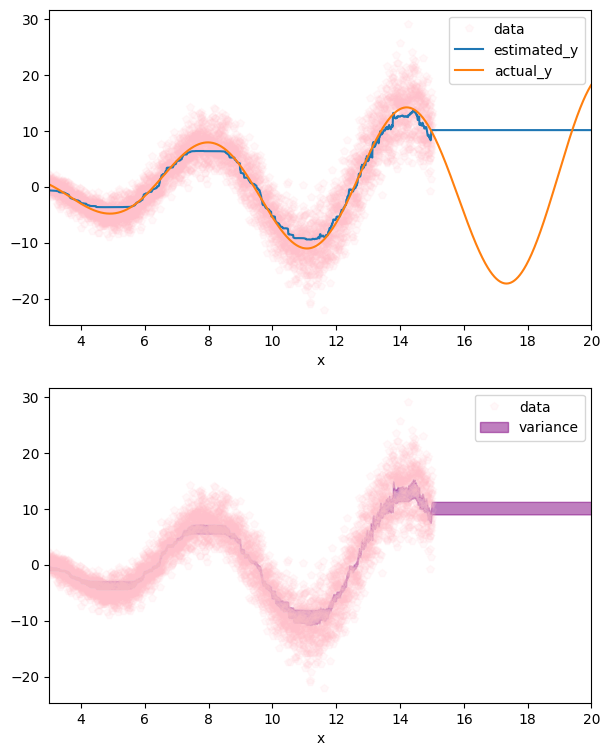

In [50]:

fig = plt.figure(figsize=(7,9))

ax = fig.add_subplot(2,1,1)
ax.plot(X_train,y_train,"p",alpha=0.1,c="pink",label="data")
ax.plot(x_test,y_pred,label="estimated_y")
ax.plot(x_test, y_test, label = "actual_y")
ax.set_xlabel("x")
ax.set_xlim(*xlim)
ax.legend()

ax = fig.add_subplot(2,1,2)
ax.plot(X_train,y_train,"p",alpha=0.1,label="data",c="pink")
# ax.plot(x_test,y_pred,label="estimated_y", c="skyblue")
ax.fill_between(x_test, y_pred - uncertainties, y_pred + uncertainties, alpha = 0.5, label="variance", color="purple")
ax.set_xlabel("x")
ax.set_xlim(*xlim)
ax.legend()
plt.show()